In [123]:
import pandas as pd 
from matplotlib import pyplot as plt 
%matplotlib inline 
import matplotlib_venn
import re 
import numpy as np 
import glob
import gzip 

import os 
output_dir = '../output/extracting_string_interactions_subnetworks/'
if not os.path.exists(output_dir): os.makedirs(output_dir)

## Loading gene list from class

In [124]:
synapse_fn = '../data/synapse_genes.txt'
with open(synapse_fn) as f:
    class_genes = set([x.strip() for x in f])

## Loading gene list from OMIM 

In [125]:
omim_fns = glob.glob('../output/omim_psychiatric_disease_genes/*')
omim_disease_genes = []
for fn in omim_fns:
    with open(fn) as f:
        genes = [x.strip() for x in f.readlines()]
        omim_disease_genes.extend(genes)
omim_disease_genes = set(omim_disease_genes)
#print('\n'.join(omim_disease_genes))
class_plus_omim = class_genes.union(set(omim_disease_genes))

In [126]:
len(omim_disease_genes)

189

## Loading gene list from StringDB annotation search 

In [128]:
prot_fn = '../data/StringDB/9606.protein.info.v11.0.txt'
prot_data = {}
stringdb_anno_genes = set()
with open(prot_fn) as f: 
    next(f)
    for line in f: 
        gene_id, gene_name, prot_size, anno = line.strip().split('\t') 
        synapse_anno = True if re.search('[Ss]ynap', anno) else False
        if synapse_anno: 
            stringdb_anno_genes.add(gene_name)
        prot_data[gene_id] = [gene_name, prot_size, anno]

## Analyzing the difference between the synapse gene sets 

In [129]:
num_class_genes = len(class_genes)
num_omim_genes = len(omim_disease_genes)
num_anno_genes = len(stringdb_anno_genes)

# Making a union of all gene lists 
complete_list = class_genes.union(omim_disease_genes, stringdb_anno_genes)
num_complete_list = len(complete_list)

# Making a dataframe for visualization 
complete_list_df = \
    pd.DataFrame([num_class_genes, num_omim_genes, num_anno_genes, num_complete_list])
complete_list_df.index = ['class', 'omim', 'anno', 'total']

In [130]:
complete_list_df

,0
class,1126
omim,189
anno,427
total,1460


## Filtering StringDB interactions for synapse genes 

In [131]:
stringdb_fn = '../data/StringDB/9606.protein.links.full.v11.0.txt.gz'

### Option 1

Make a subnetwork of the 1,460 synpase genes 

In [52]:
inters_fns = {}

In [53]:
option = 1 
#confidence_score = 0.9
inters_fn = os.path.join(output_dir, 'synapse_inters_option_{}.tsv')
inters_fn = inters_fn.format(option)
inters_fns[option] = inters_fn

with gzip.open(stringdb_fn) as fr, open(inters_fn, 'w') as fw: 
    header = next(fr).decode()
    
    for line in fr: 
        
        line = line.decode()
        line = line.split()
        node1 = line[0]
        node2 = line[1]
        
        node1_name = prot_data[node1][0]
        node2_name = prot_data[node2][0]
        
        if node1_name in complete_list and \
                node2_name in complete_list: 
                
            combined_score = float(line[-1]) / 1000
            s = [node1_name, node2_name, combined_score]
            s = [str(x) for x in s]
            s = '\t'.join(s) + '\n'
            fw.write(s)

### Option 2

Make a subnetwork of the 1,460 synpase genes, keep interactions with confidence >= 0.4


In [81]:
option = 2 
confidence_score = 0.4
inters_fn = os.path.join(output_dir, 'synapse_inters_option_{}.tsv')
inters_fn = inters_fn.format(option)
inters_fns[option] = inters_fn

with gzip.open(stringdb_fn) as fr, open(inters_fn, 'w') as fw: 
    header = next(fr).decode()
    for line in fr: 
        
        line = line.decode()
        line = line.split()
        node1 = line[0]
        node2 = line[1]
        
        node1_name = prot_data[node1][0]
        node2_name = prot_data[node2][0]
        
        if node1_name in complete_list and \
                node2_name in complete_list: 
                
            combined_score = float(line[-1]) / 1000
            if combined_score >= confidence_score: 
                s = [node1_name, node2_name, combined_score]
                s = [str(x) for x in s]
                s = '\t'.join(s) + '\n'
                fw.write(s)
        

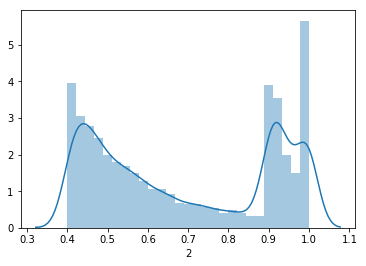

In [155]:
df = pd.read_table(inters_fn, header=None)
df[2].describe()
s = df[2]
import seaborn as sns 
sns.distplot(s, )

### Option 3

Make a subnetwork of the 1,460 synpase genes, add first order interactions where one gene is a synapse and the other is non-symapse if confidence >= 0.9

In [97]:
option = 3
confidence_score = 0.999
inters_fn = os.path.join(output_dir, 'synapse_inters_option_{}.tsv')
inters_fn = inters_fn.format(option)
inters_fns[option] = inters_fn

with gzip.open(stringdb_fn) as fr, open(inters_fn, 'w') as fw: 
    header = next(fr).decode()
    for line in fr: 
        
        line = line.decode()
        line = line.split()
        node1 = line[0]
        node2 = line[1]
        
        node1_name = prot_data[node1][0]
        node2_name = prot_data[node2][0]
        
        if node1_name in complete_list and \
                node2_name in complete_list: 
            combined_score = float(line[-1]) / 1000
            s = [node1_name, node2_name, combined_score]
            s = [str(x) for x in s]
            s = '\t'.join(s) + '\n'
            fw.write(s)
                
        elif node1_name in complete_list or \
                node2_name in complete_list: 
                
            combined_score = float(line[-1]) / 1000
            if combined_score >= confidence_score: 
                s = [node1_name, node2_name, combined_score]
                s = [str(x) for x in s]
                s = '\t'.join(s) + '\n'
                fw.write(s)
        

### Option 4

Make a subnetwork of the 1,460 synpase genes, keep interactions with confidence >= 0.4. Then addd first order interactions where one gene is a synapse and the other is non-symapse if confidence >= 0.999.

In [ ]:
option = 4
confidence_score_a = 0.4
confidence_score_b = 0.999

inters_fn = os.path.join(output_dir, 'synapse_inters_option_{}.tsv')
inters_fn = inters_fn.format(option)
inters_fns[option] = inters_fn

with gzip.open(stringdb_fn) as fr, open(inters_fn, 'w') as fw: 
    header = next(fr).decode()
    for line in fr: 
        
        line = line.decode()
        line = line.split()
        node1 = line[0]
        node2 = line[1]
        
        node1_name = prot_data[node1][0]
        node2_name = prot_data[node2][0]
        
        if node1_name in complete_list and \
                node2_name in complete_list: 
            
            combined_score = float(line[-1]) / 1000
            if combined_score >= confidence_score_a: 
                s = [node1_name, node2_name, combined_score]
                s = [str(x) for x in s]
                s = '\t'.join(s) + '\n'
                fw.write(s)
                
        elif node1_name in complete_list or \
                node2_name in complete_list: 
                
            combined_score = float(line[-1]) / 1000
            if combined_score >= confidence_score_b: 
                s = [node1_name, node2_name, combined_score]
                s = [str(x) for x in s]
                s = '\t'.join(s) + '\n'
                fw.write(s)
        

## Investigating the number of genes 

In [139]:
def find_genes_in_interactions_file(fn):
    
    final_stringdb_genes = set()
    with open(fn, 'r') as f:

        for line in f: 

            line = line.split()
            node1 = line[0]
            node2 = line[1]        
            final_stringdb_genes.add(node1)
            final_stringdb_genes.add(node2)
            
    return(final_stringdb_genes)

In [140]:
op1 = find_genes_in_interactions_file(inters_fns[1])
op2 = find_genes_in_interactions_file(inters_fns[2])
op3 = find_genes_in_interactions_file(inters_fns[3])
op4 = find_genes_in_interactions_file(inters_fns[4])

In [144]:
inters_fns[4]

'../output/extracting_string_interactions_subnetworks/synapse_inters_option_4.tsv'

In [143]:
len(op4)

1680

In [141]:
num_genes_in_ops = [len(op1), len(op2), len(op3), len(op4)]

In [142]:
print('Number of genes in ops:' , ', '.join([str(x) for x in num_genes_in_ops]))

Number of genes in ops: 1288, 1283, 1685, 1680


In [135]:
def count_file_lines(fn):
    with open(fn) as f: 
        return(len(f.readlines()))

In [136]:
num_inters_in_ops = [count_file_lines(inters_fns[i]) for i in range(1, 5)]

In [137]:
print('Number of interactions in ops:' , ', '.join([str(x) for x in num_inters_in_ops]))

Number of interactions in ops: 251066, 52044, 255340, 56318


In [138]:
print(len(class_genes.intersection(op3)),
len(omim_disease_genes.intersection(op3)),
len(stringdb_anno_genes.intersection(op3)),
len(stringdb_anno_genes.intersection(op3)))

1098 45 426 426
